### Математические пакеты
## Лабораторная работа № 1 Основы цифровой обработки сигналов
Выполнил студент гр. 9381 Гурин Семен 
Вариант 3
### Цель работы
Иизучить возможности библиотек Python для решения задач цифровой обработки сигналов.
### Задачи лабораторной работы
1 Освоить Jupyter Notebook.

2 Выполнить загрузку аудио сигнала и построить огибающую (график).

3 Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный сигнал.

4 Детектор сигнал/шум. Получить сигнал после детектирования

5 Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.

6 Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.
### Выполнение работы
#### Построение огибающей
Имеется сигнал $x(i), i = 0,1,...N-1$. Хотим построить огибающую $y(j),j = 0,1,...,n-1$

Пусть $m = [\frac{N}{n}] $ - число точек в интервале усреднения.

Тогда $y(j) = \frac{1}{m} \sum_{k=m*j}^{mj+m-1}|x(k)|$

In [8]:
from scipy.io import  wavfile
from scipy import signal

import matplotlib.pyplot as plt
import scipy.io
import numpy

/opt/sagemath-9.2/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.
/opt/sagemath-9.2/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: WavFileWarning: Incomplete chunk ID: b'\x00', ignoring it.
  """Entry point for launching an IPython kernel.


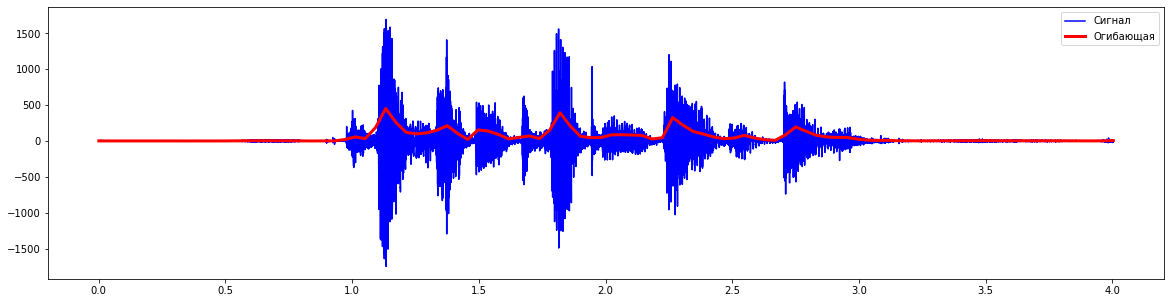

In [9]:
framerate, data = wavfile.read("03-01-05-01-01-01-03_A3.wav")
n = 100
m = len(data) // n
env = []

for j in range(n):
    amount = 0
    for k in range(m * j, m * j + m): # Тут не надо вычитать 1, как в формуле, т.к. range идёт по элементам (0, n - 1)
        amount += abs(data[k])
    env.append(amount / m)

plt.figure(figsize=(20, 5))
plt.plot(numpy.linspace(0, len(data) / framerate, num=len(data)), data, color='blue', label='Сигнал')
plt.plot(numpy.linspace(0, len(data) / framerate, num=len(env)), env, color='red', linewidth=3.0, label='Огибающая')
plt.legend()

#### Фильтрация (ФНЧ)
ФНЧ(Фильтр нижниъ частот)- подавляет частоты сигнала выше частоты среза данного фильтра.

Пусть $F_d$ - частота дисеретизации, частота среза - $F_s$, порядок фильтра - $m$. Тогда вычисляем $wn = 2 \frac{F_d}{F_s}$

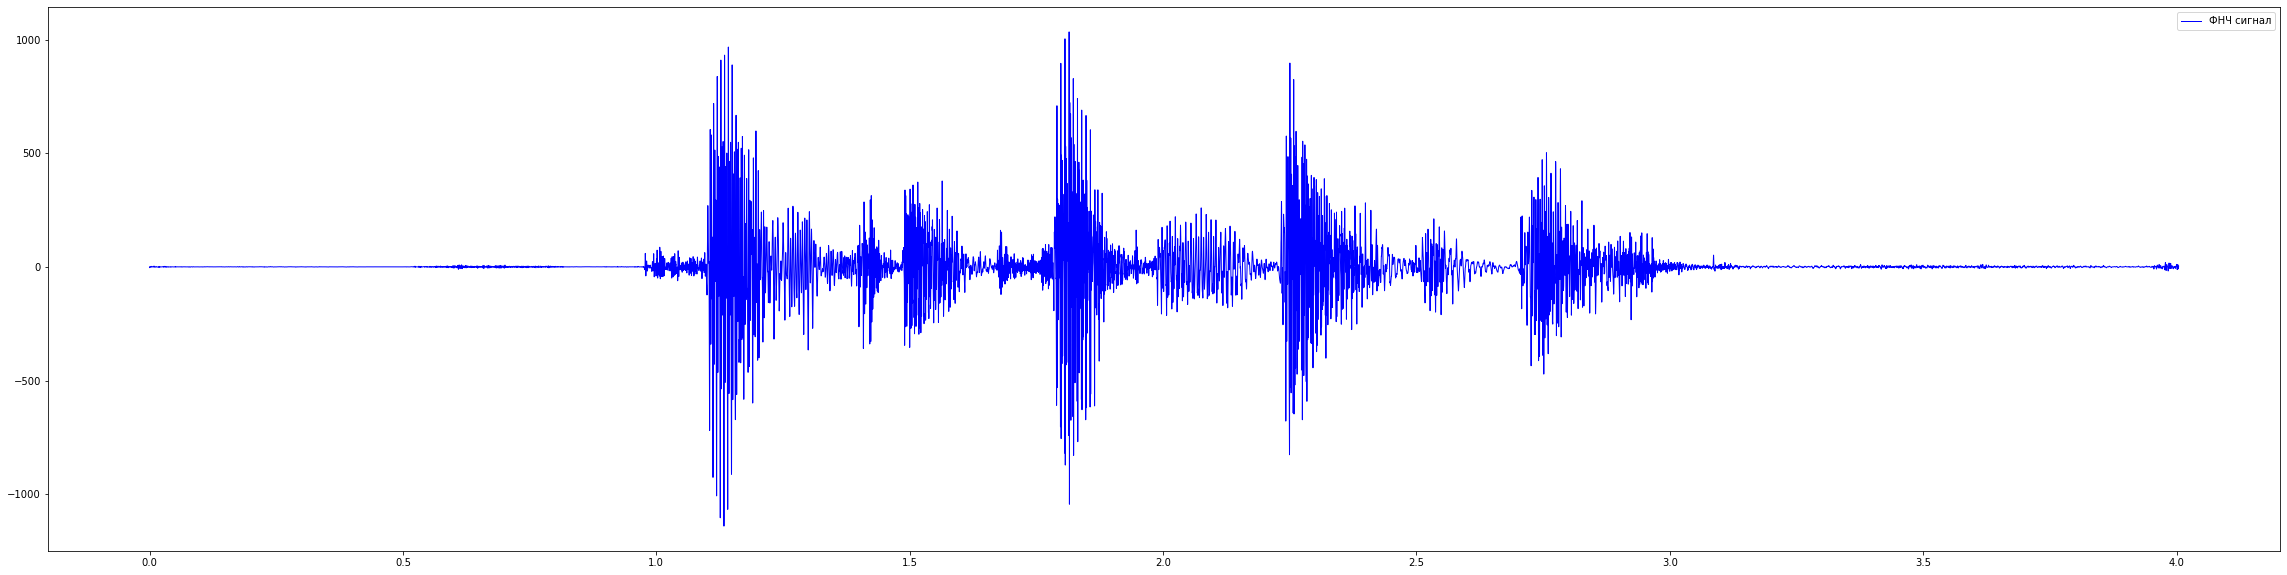

In [10]:
def LPF(_data, Fd):
    Fs = 1000
#   Fd = framerate
    m = 2
    wn = 2 * Fs / Fd
    b, a = signal.butter(m, wn, 'lowpass')
    return signal.filtfilt(b, a, _data)

filtedData = LPF(data, framerate)
wavfile.write('lowpass.wav', framerate, filtedData.astype(numpy.int16))

plt.figure(figsize=(40, 10))
plt.plot(numpy.linspace(0, len(data) / framerate, num=len(data)), filtedData, color='blue', label='ФНЧ сигнал', linewidth=1)
plt.legend()

#### Амплитудный детектор сигнал/шум
Определяем среднее сигнала по амплитуде(без учета знака): $mid = \frac{1}{N}\sum_{k=0}^{N-1}|x(k)|$

Определяем порог детектора — $Th = \alpha ∗mid$, где $0 < \alpha < 1$ подбирается экспериментально.
Задаем величину ”провала”(в отсчетах) — $k$. Обозначим $y(i)$ — сигнал после детектирования.

$\ \bullet\ Событие\ ”начало\ сигнала”$. Если $x(i)$ в течении $k$ отсчетов превышает порог, $y(i) = x(i)$.

$\ \bullet\ Событие\ ”окончание\ сигнала”$. Если $x(i)$ в течении $k$ отсчетов меньше порога, $y(i) = 0$

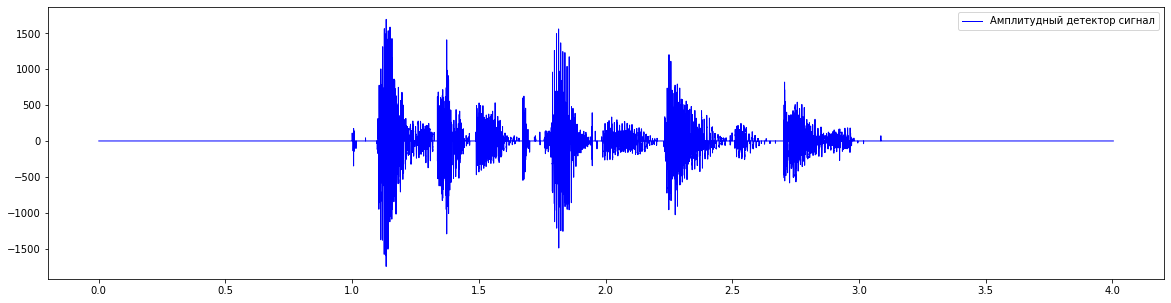

In [11]:
mid = 0
for i in range(len(data)):
    mid += abs(data[i])
mid /= len(data)

Th = 0.5 * mid

k = 15
y = numpy.zeros(len(data))

count_B = 0
count_E = 0
for i in range(len(data)):
    if abs(data[i]) > Th:
        count_B += 1
        count_E = 0
        if count_B >= k:
            y[i] = data[i]
    else:
        count_E += 1
        count_B = 0
        
wavfile.write('detected.wav', framerate, y.astype(numpy.int16))

plt.figure(figsize=(20, 5))
plt.plot(numpy.linspace(0, len(data) / framerate, num=len(data)), y, color='blue', label='Амплитудный детектор сигнал', linewidth=1)
plt.legend()

#### Эхо (простейший ревербератор)
$\ \bullet$ Ревебратор реализован, как набор линий задержки. Число линий задержки $N_L > 8$

$\ \bullet$ Каждая линия задержки имеет свой весовой коэффициент (задается пользователем): $ \alpha_1 > \alpha _2 > ... > \alpha N_L $

$\ \bullet$ Перед добавлением к исходному сигналу, выход ревебратора фильтруется ФНЧ-фильтром первого порядка.

$\ \bullet$ Желаемое соотношение между "сухим" и обработанным сигналом задается коэффициентом примеримости $\gamma$

$\ \bullet$ Ревебратор может работать в двух режимах: ручной и с использованием готовой конфигурации (present). Для ручного режима, регулируемого пользователем, задается максимальная задержка $D_1$, а величины остальеых определяются автоматически через нее: $D_i = D_1 2^\frac{1-i}{N_L}, i = 2,...,N_L$

In [13]:
dist = 20.0 / 335.0
speed = 335
g = 0.7
Nl = 8
D = [0]*Nl
a = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

D[0] = dist
for i in range(1, Nl):
    D[i] = D[0]* pow(2, (1-i)/Nl)

procData = numpy.zeros(int((numpy.sum(D) + len(data) / framerate + 1) * framerate))
for i in range(len(data) -1):
    amount = 0
    for j in range(Nl):
        amount += D[j]
        procData[i + int(amount * framerate)] += data[i] * a[j]
        
echo = LPF(procData, framerate) * g

for i in range(len(data)):
    echo[i] += data[i]

wavfile.write('echo.wav', framerate, echo.astype(numpy.int16))

#### Классический Distortion (опционально)
Обозначим входной сигнал и выходной сигнал, соответственно как $x(i)$ и $y(i)i = 0,1...,N-1$. Пользователь задает порог Th и максимальное значение сигнала $Max > Th$. Тогда $Y(i) = \begin{cases}x(i), & |x(i)| \leqslant Th\\Max*sign(x(i)), & |x(i)| > Th\end{cases}$ 

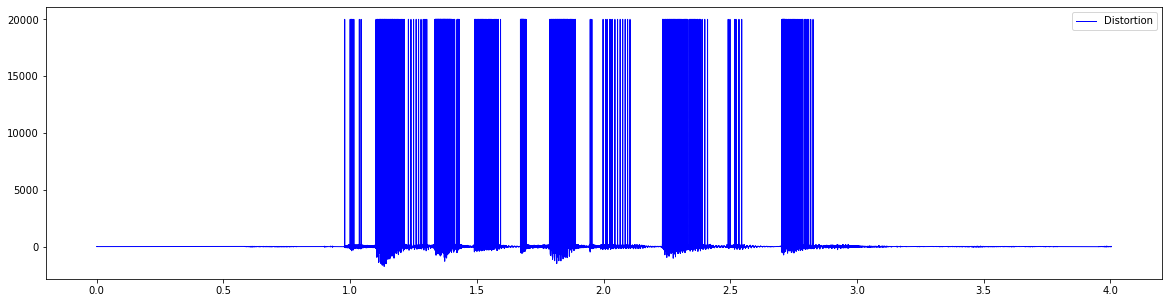

In [14]:
y = numpy.zeros(len(data))
Th = 200
Max = 20000

for i in range(len(data)):
    if abs(data[i] <= Th):
        y[i] = data[i]
    else:
        y[i] = Max * numpy.sign(data[i])

wavfile.write('distortion.wav', framerate, y.astype(numpy.int16))

plt.figure(figsize=(20, 5))
plt.plot(numpy.linspace(0, len(data) / framerate, num=len(data)), y, color='blue', label='Distortion', linewidth=1)
plt.legend()

### Вывод
При выполнении лабораторной работы был освоен Jupiter, изучены технологии загрузки аудио сигнала и построения его огибающей. Так же были изучены технологии фильрации, детектора сигнала и эффекта эхо. В качестве дополнения был изучен эффект "Disturtion". В итоге прошло ознакомление с математическими пакетами на языке Python для цифровой обработки аудио сигналов формата .wav. 